# Fake news data analysis on the FakeNewsNet dataset

The purpose of this project is to analyze the news articles and tweets from the [FakeNewsNet dataset](https://github.com/KaiDMML/FakeNewsNet). 

In [1]:
import re
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from io import StringIO
from scipy import special

from pandarallel import pandarallel

from sklearn import svm
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import PCA, TruncatedSVD, LatentDirichletAllocation
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from joblib import dump, load

import nltk
from nltk.tokenize import word_tokenize, TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import *

nltk.download("stopwords")
nltk.download('punkt')
nltk.download('wordnet')

sns.set_theme()

from utils import collect_tweets, collect_news

%matplotlib inline


[nltk_data] Downloading package stopwords to /home/jakob/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/jakob/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jakob/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
root_dir = "/mnt/213A37C1342A39BE/Projects/FakeNewsNet/code/fakenewsnet_dataset/"

datasets = [
    "politifact",
    "gossipcop"
]

random_state = 42    # For reproducable random initialization 
pandarallel.initialize(use_memory_fs=True)  # initialization for pandas multiprocessing


INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


## Analyzing news articles

The first part of the analysis will be focused on analysing the news articles. We load them into memory using helper functions defined in ``utils.py``.

In [3]:
politifact_news = pd.read_json(StringIO(collect_news(root_dir + datasets[0])))
politifact_news

,url,text,images,top_img,keywords,authors,canonical_link,title,meta_data,movies,publish_date,source,summary,truth
0,http://www.senate.gov/legislative/LIS/roll_cal...,Roll Call Vote 111th Congress - 1st Session\n\...,[http://www.senate.gov/resources/images/usFlag...,http://www.senate.gov/resources/images/us_sen.ico,[],[],,U.S. Senate: U.S. Senate Roll Call Votes 111th...,"{'viewport': 'width=device-width, initial-scal...",[],NaN,http://www.senate.gov,,real
1,http://www.politico.com/news/stories/0509/2241...,Barack Obama ended up in the middle of an unli...,"[data:image/gif;base64,R0lGODlhAQABAAAAACH5BAE...",http://s3-origin-images.politico.com/news/0905...,[],[Alexander Burns],https://www.politico.com/story/2009/05/trump-o...,Trump on Prejean: Same as Obama,"{'article': {'opinion': 'false'}, 'og': {'titl...",[],1.242120e+09,http://www.politico.com,,real
2,http://pollingreport.com/CongJob.htm,Follow @pollreport CONGRESS – Job Rating See a...,[http://pollingreport.com/images/logo3.gif],,[],[],,Congress: Job Ratings,"{'GENERATOR': 'Microsoft FrontPage 5.0', 'Micr...",[],NaN,http://pollingreport.com,,real
3,https://web.archive.org/web/20090514023215/htt...,House GOP Introduces Keep Terrorists Out of Am...,[https://web.archive.org/web/20090514023215im_...,https://web.archive.org/web/20090514023215im_/...,[],[],,House GOP Introduces Keep Terrorists Out of Am...,{},[],NaN,https://web.archive.org,,real
4,https://web.archive.org/web/20061116002411/htt...,'); //--> E-mail | Print | Comments | Request ...,[https://web.archive.org/web/20061116002411im_...,https://web.archive.org/web/20061116002411im_/...,[],[Robert Lenzner],,Is The End In Sight For Supermax?,{'description': 'Americas most secure and most...,[],1.145052e+09,https://web.archive.org,,real
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
921,http://channel24news.com/2017/06/manager-kille...,10:30 pm last night police received a call abo...,[https://pranksocial.com/wp-content/uploads/20...,https://channel24news.com/wp-content/uploads/2...,[],[],https://channel24news.com/2017/06/manager-kill...,Manager killed 10 employees at checkers on 183...,"{'viewport': 'width=device-width, initial-scal...",[],1.498167e+09,http://channel24news.com,,fake
922,https://web.archive.org/web/20170629142109/htt...,"WASHINGTON, D.C. (AP) — At a press conference ...",[https://web.archive.org/web/20170629142109im_...,https://web.archive.org/web/20170629142109im_/...,[],"[Jimmy Rustling, Born At An Early Age, Jimmy R...",https://web.archive.org/web/20170629142109/htt...,Paul Ryan: “Donald Trump Plans To Resign From ...,"{'viewport': 'width=device-width, initial-scal...",[],1.498617e+09,https://web.archive.org,,fake
923,http://politicot.com/spicer-trump-legal-right-...,For full functionality of this site it is nece...,"[data:image/x-icon;,]","data:image/x-icon;,",[],[],,,"{'viewport': 'width=device-width,initial-scale...",[],NaN,http://politicot.com,,fake
924,https://web.archive.org/web/20170625021133/htt...,"As we promised, Freedom Crossroads has just le...",[https://web.archive.org/web/20170625021133im_...,https://web.archive.org/web/20170625021133im_/...,[],[],https://web.archive.org/web/20170625021133/htt...,BREAKING: The Democrat James Comey Has Been Ha...,"{'viewport': 'width=device-width, initial-scal...",[],1.498078e+09,https://web.archive.org,,fake


Our dataset consists of 926 rows, each representing one news article. We can also see that, although there are 14 columns representing various features of those articles, there is often missing data in most of them. For the purposes of this analysis, we will limit ourselves to 3 columns that probably carry the most information: *text*, *title* and *truth*. 

In [4]:
text_data = politifact_news[["text", "title", "truth"]]
del politifact_news # forget data so we don't run out of memory
text_data

,text,title,truth
0,Roll Call Vote 111th Congress - 1st Session\n\...,U.S. Senate: U.S. Senate Roll Call Votes 111th...,real
1,Barack Obama ended up in the middle of an unli...,Trump on Prejean: Same as Obama,real
2,Follow @pollreport CONGRESS – Job Rating See a...,Congress: Job Ratings,real
3,House GOP Introduces Keep Terrorists Out of Am...,House GOP Introduces Keep Terrorists Out of Am...,real
4,'); //--> E-mail | Print | Comments | Request ...,Is The End In Sight For Supermax?,real
...,...,...,...
921,10:30 pm last night police received a call abo...,Manager killed 10 employees at checkers on 183...,fake
922,"WASHINGTON, D.C. (AP) — At a press conference ...",Paul Ryan: “Donald Trump Plans To Resign From ...,fake
923,For full functionality of this site it is nece...,,fake
924,"As we promised, Freedom Crossroads has just le...",BREAKING: The Democrat James Comey Has Been Ha...,fake


The data is now much more dense than before and therefore much easier to analyise. As a first step in our analysis, we will take a look at the numbers of real and fake news articles.

In [5]:
text_data['truth'].value_counts()

real    540
fake    386
Name: truth, dtype: int64

We can see that there are slightly more real articles than fake ones, but the numbers are still roughly comparable. We should keep this in mind when interpreting the results of later analysis. Because our dataset is structured so that real articles always come before fake ones, we can now also set a boundary constant that indicates where the split occures in our dataset. This will be useful later on.

In [6]:
boundary = 540

Before we can actually analyze our text data, we will need to clean it, tokenize it (split it into individual words or tokens), lemmatize it and finally transform it into a numerical format suitable for analysis. We start by defining a general tokenization and cleaning function, which we then apply on the text fields of our data. We will be using parallel implementations of certain pandas functions to speed everything up by utilizing multiple CPU cores. 

In [7]:
def tokenize_clean(data, fields, tokenizer=None):
    punctuation = set('!"$%&\'’()*+,-./:;<=>?[\\]^_`{|}~•@#—–‘')
    punctuation.add("``")
    punctuation.add("''")
    punctuation.add("--")
    punctuation.add("”")
    punctuation.add("“")
    # "..." also appears but carries semantic meaning so we leave it in

    data = data.apply(lambda x: x.astype(str).str.lower())
    data[fields] = data[fields].parallel_applymap(
        lambda x: re.sub(r"http\S+", "", x)) # remove links
    if tokenizer:
        data[fields] = data[fields].parallel_applymap(tokenizer.tokenize)
        print("Using tokenizer: {}".format(tokenizer))
    else:   # use defualt tokenizer
        data[fields] = data[fields].parallel_applymap(word_tokenize)
        print("Using default tokenizer")
    data[fields] = data[fields].parallel_applymap(set)
    data[fields] = data[fields].parallel_applymap(
        lambda x: x - set(stopwords.words('english')))
    data[fields] = data[fields].parallel_applymap(lambda x: x - punctuation)
    return data


In [8]:
text_data = tokenize_clean(text_data, ["text", "title"])
text_data

Using default tokenizer


,text,title,truth
0,"{amendment, call, r-oh, s., information, d-nd,...","{call, 111th, u.s., congress, votes, senate, r...",real
1,"{stated, president, addressing, california, ec...","{prejean, obama, trump}",real
2,"{3/1/21, 10, 7/27-29/08, 10/25-29/08, 9/27-30/...","{job, ratings, congress}",real
3,"{federal, confronting, pre-approve, regarding,...","{terrorists, house, gop, introduces, act, keep...",real
4,"{federal, maximum, kind, facility, solution, p...","{end, supermax, sight}",real
...,...,...,...
921,"{10, call, night, police, gun, fire, 10:30, to...","{manager, 10, 183st, checkers, killed, employe...",fake
922,"{holdings, donation, progress, property, near,...","{ryan, 30, resign, plans, donald, trump, days,...",fake
923,"{web, instructions, necessary, enable, browser...",{},fake
924,"{none, liberal, really, probably, staff, affai...","{comey, affair, revealed, breaking, james, dem...",fake


We can see that the textual fields are now nicely split into into individual tokens. We also notice that at least one of the titles is now empty. This is probably because that title contained only stopwords, which were removed during cleaning. Our next step is defining a general stemming and lemmatization function and apply it to out data.

In [9]:
def stem_lemmatize(data, fields):
    p_stemmer = PorterStemmer()
    wordnet_lemmatizer = WordNetLemmatizer()
    data[fields] = data[fields].parallel_applymap(
        lambda x: list(map(lambda token: p_stemmer.stem(token), x)))
    data[fields] = data[fields].parallel_applymap(
        lambda x: list(map(lambda token: wordnet_lemmatizer.lemmatize(token), x)))
    return data

In [10]:
text_data = stem_lemmatize(text_data, ["text", "title"])
text_data

,text,title,truth
0,"[amend, call, r-oh, s., inform, d-nd, name, 10...","[call, 111th, u.s., congress, vote, senat, roll]",real
1,"[state, presid, california, address, echo, bar...","[prejean, obama, trump]",real
2,"[3/1/21, 10, 7/27-29/08, 10/25-29/08, 9/27-30/...","[job, rate, congress]",real
3,"[feder, confront, pre-approv, regard, legisl, ...","[terrorist, gop, hous, introduc, act, keep, am...",real
4,"[feder, maximum, kind, facil, solut, per-cel, ...","[end, supermax, sight]",real
...,...,...,...
921,"[10, call, night, polic, gun, fire, 10:30, ton...","[manag, 10, 183st, checker, kill, employe, 27ave]",fake
922,"[hold, donat, progress, properti, near, big, 7...","[ryan, 30, resign, plan, donald, trump, day, p...",fake
923,"[web, instruct, necessari, enabl, browser, sit...",[],fake
924,"[none, liber, realli, probabl, staff, affair, ...","[comey, affair, reveal, break, jame, democrat,...",fake


The final step before we can start more serious analysis is transforming the dataset into a numerical matrix. Although there are many different ways to do this, we will start with the simplest one: we will construct a term-document matrix, where each row represents a document (in our case a news article) and each column represents a term (in our case a token). The matrix elements are the number of occurances of said token in said article. This can be simply done using scikit-learn's **CountVectorizer**. Because artices usually don't contain that many tokens (relative to the whole corpus vocabulary), the resulting matrix will be sparse. 

In [11]:
vectorizer = CountVectorizer(
    lowercase=False,
    preprocessor=lambda x: x,
    stop_words=None,
    tokenizer=lambda x: text_data["text"][int(x)]
)

embedding = vectorizer.fit_transform([str(i) for i in range(len(text_data["text"]))])
embedding


<926x29509 sparse matrix of type '<class 'numpy.int64'>'
	with 221742 stored elements in Compressed Sparse Row format>

We can see that the resulting has 29510 columns, indicating we have that many unique tokens in our corpus. Now, we can use this matrix to calculate the number of occurances of individual tokens in the whole corpus. We write a general function that calculates the counts of all tokens that occur at least a certian threshold number of times.

In [12]:
def frequent_tokens(embedding, threshold=2):
    counts = embedding.sum(axis=0)
    tokens = pd.DataFrame(data=[(token, counts[0, i])
            for token, i in vectorizer.vocabulary_.items() if (counts[0, i] >= threshold)], columns=['token', 'score'])
    tokens.sort_values(by=['score'], inplace=True, ascending=False)
    return tokens

In [13]:
tokens = frequent_tokens(embedding)
tokens

,token,score
779,say,594
396,work,587
59,state,571
390,make,553
609,use,541
...,...,...
3587,dampen,2
8271,contamin,2
3581,slog,2
8278,margaret,2


We see that most common tokens are general verbs like *say*, *make* and *use*, and they appear roughly 500 times in a corpus of 926 articles. From the total vocabulary of lmost 30k tokens, only around a third appear at least 2 times. This is an interesting observation that's in line with the theory, which states that word frequencies usually follow the Zipfian distribution. We can also plot the actual distribution and compare it to the Zipfian one.

(0.0, 0.05)

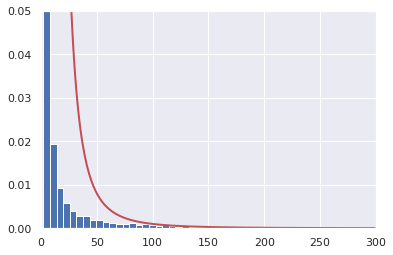

In [14]:
a = 3
x = np.arange(10.0, 300.0)
y = x**(-a) / special.zetac(a)
count, bins, ignored = plt.hist(tokens['score'], bins=100, density=True)
plt.plot(x, y/max(y), linewidth=2, color='r')
ax = plt.gca()
ax.set_xlim([0, 300])
ax.set_ylim([0, 0.05])

Now back to our matrix. Since we can't visualize it directly because of it's high dimensionality, we need to apply some dimensionality reduction techniques. One of the simplest ones is **Principal Component Analysis**, or **PCA** for short. We will use it to project our data from an almost 30k-dimensional vocabulary space into a 2-dimensional one, while preserving as much variance as possible.

In [15]:
pca = TruncatedSVD(n_components=2, random_state=random_state)
projection = pca.fit_transform(embedding)
projection.shape


(926, 2)

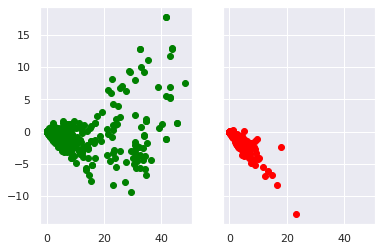

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True)
ax1.scatter(projection[:boundary, 0], projection[:boundary, 1], c='green')
ax2.scatter(projection[boundary:, 0], projection[boundary:, 1], c='red')

If we plot the projections of real and fake articles, we see that there is a visible difference in their distributions. The real articles are also much more spread out, while the fake ones are more concentrated. 

In [17]:
pca.explained_variance_ratio_

array([0.25643855, 0.01681916])

If we look at the fraction of preserved variance, we can see that a quarter of all variance is already contained in the direction of the first principal component, which is a lot.

Next, we can take a closer look at the real articles in the upper right corner that are far away from the fake ones. 

In [18]:
text_data.iloc[np.where(np.fromiter(map(lambda x: x[0]>30 and x[1]>5, projection), dtype=bool))[0]]

,text,title,truth
59,"[10, kind, renown, practic, respons, back, '50...","[associ, presid, press, remark, luncheon]",real
98,"[10, understand, kind, professor, forth, sell,...","[mccain, obama, go, head, last, debat]",real
109,"[10, understand, kind, reli, respons, forth, p...","[mccain, transcript, obama, second, debat]",real
119,"[10, kind, gray, back, solar, along, worker, p...","[presid, il, knox, remark, economi, colleg, ga...",real
120,"[10, kind, gray, back, solar, along, worker, p...","[presid, il, knox, remark, economi, colleg, ga...",real
122,"[10, understand, kind, professor, forth, sell,...","[2008, cpd, transcript, debat]",real
139,"[10, kind, paper, germani, respons, entreprene...","[presid, remark, hall, town, twitter]",real
181,"[10, kind, understand, 22:11:10, innermountain...","[transcript, 's, wednesday, presidenti, debat]",real
182,"[10, kind, understand, 22:11:10, innermountain...","[transcript, 's, wednesday, presidenti, debat]",real
187,"[10, kind, understand, subtext, respons, forth...","[gop, presid, hous, issu, confer, remark]",real


One interesting fact we can notice is that most of the titles of these articles contain the word *transcript*. Although our projection was done on the text part of the articles and not on the titles, we can speculate that title tokens almost alway appear in the text as well. To look further into it, we can write a function that counts the frequency of a given token in real and fake article texts. 

In [19]:
def word_truths(text_data, word, normalize=False):
    return text_data[text_data['text'].apply(
        lambda x: word in x)]['truth'].value_counts(normalize=normalize)

In [20]:
word_truths(text_data, 'transcript')

real    52
fake     3
Name: truth, dtype: int64

We can clearly see that the token *transcript* is very highly associated with real articles. To take this analysis even further, we can calculate the proportion of occurances in real articles for every token. 

In [21]:
tokens['real_pct'] = tokens['token'].parallel_apply(lambda x: word_truths(
    text_data, x, normalize=True))['real']
tokens.sort_values(by='real_pct', ascending=False, inplace=True)
tokens

,token,score,real_pct
8278,margaret,2,1.0
9769,classif,4,1.0
6013,tapestri,2,1.0
6055,huntsman,2,1.0
6056,signifi,2,1.0
...,...,...,...
10841,starbuck,2,NaN
10831,freak,2,NaN
10838,ejacul,2,NaN
10832,costum,2,NaN


We see that although some tokens do oappear exclusively in real or fake articles, their overall frequencies are all very low. The usefulness of the token *transcript* is higher especially because it appears much more often in general, yet is still almost exclusively assosiated with real articles. 

Let us return to our projection. We can see from the graphs that the projection looks like it could be reasonably well separated with a linear classifier. To test this, we train a linear SVM model on a part of our data and test it on another one. 

In [22]:
labels = np.array([1 if truth == "real" else 2 for truth in text_data['truth']])

X_train, X_test, y_train, y_test = train_test_split(
    projection, labels, test_size=0.2, random_state=random_state)
svm_classifier = svm.SVC(kernel='linear')
svm_classifier.fit(X_train, y_train)
accuracy_score(y_test, svm_classifier.predict(X_test))

0.7903225806451613

We can see that the classifier achieves an almost 80% accuracy. To further help us visualize it's accuracy, we can plot it's decision boundary.

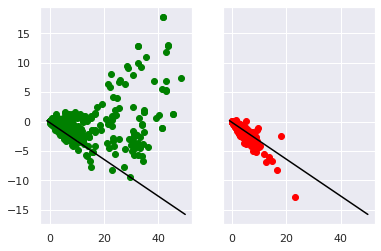

In [23]:
w = svm_classifier.coef_[0]
b = svm_classifier.intercept_[0]
x_points = np.linspace(-1, 50)
y_points = -(w[0] / w[1]) * x_points - b / w[1]  

fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True)
ax1.scatter(projection[:boundary, 0], projection[:boundary, 1], c='green')
ax2.scatter(projection[boundary:, 0], projection[boundary:, 1], c='red')
ax1.plot(x_points, y_points, c='black')
ax2.plot(x_points, y_points, c='black')

The graphs confirm that our classifier works reasonably well. Most real articles are above the decision boundary and most fake ones are below. We can save this clissifier to use it later on.

In [24]:
dump(svm_classifier, 'models/svm_news_pca.joblib')

['models/svm_news_pca.joblib']

As we mentioned earlier, PCA is not the only dimensionality reduction technique we know. Let us try another, more advanced technique, called **t-distributed stochastic neighbor embedding** (or **t-SNE** for short). Because this is a very computationally heavy tecnhique, it is often impractical to use it directly on a high-dimensional dataset. Instead, we first project our data with PCA down to 50 components, and then apply TSNE to that.

In [25]:
intermediate_pca = TruncatedSVD(n_components=50, random_state=random_state)
tsne = TSNE(n_components=2, learning_rate='auto',
            init='random', random_state=random_state)

intermediate_matrix = intermediate_pca.fit_transform(embedding)
projection = tsne.fit_transform(intermediate_matrix)
projection.shape

(926, 2)

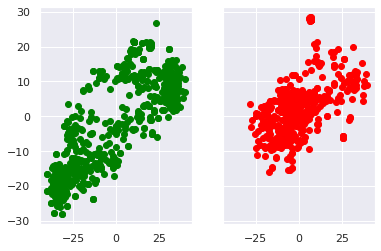

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True)
ax1.scatter(projection[:boundary, 0], projection[:boundary, 1], c='green')
ax2.scatter(projection[boundary:, 0], projection[boundary:, 1], c='red')


We see that t-SNE gives a very different projection than PCA, but unfortunately, it doesn't look as linearly separable as the PCA one. We can still try to train a linear SVM classifier on it, but don't expect good results.

In [27]:
X_train, X_test, y_train, y_test = train_test_split(
    projection, labels, test_size=0.2, random_state=random_state)
svm_classifier = svm.SVC(kernel='linear')
svm_classifier.fit(X_train, y_train)
accuracy_score(y_test, svm_classifier.predict(X_test))

0.6129032258064516

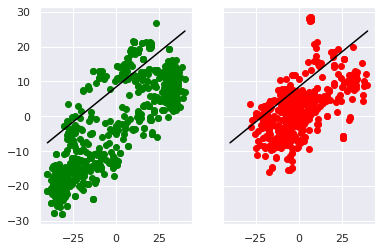

In [28]:
w = svm_classifier.coef_[0]
b = svm_classifier.intercept_[0]
x_points = np.linspace(-40, 40)
y_points = -(w[0] / w[1]) * x_points - b / w[1]

fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True)
ax1.scatter(projection[:boundary, 0], projection[:boundary, 1], c='green')
ax2.scatter(projection[boundary:, 0], projection[boundary:, 1], c='red')
ax1.plot(x_points, y_points, c='black')
ax2.plot(x_points, y_points, c='black')

Indeed, SVM preforms really badly in this case and doesn't find a meaningful decision boundary. 

We have now tried a SVM predictive model on two different projections of our term-document matrix. What about using SVM on the full matrix itself? Although we can't visualize it in any meaningful way, we can still train the model on it.

In [29]:
X_train, X_test, y_train, y_test = train_test_split(
    embedding, labels, test_size=0.2, random_state=random_state)

svm_classifier = svm.SVC(kernel='linear')
svm_classifier.fit(X_train, y_train)
accuracy_score(y_test, svm_classifier.predict(X_test))

0.7419354838709677

A linear SVM on the whole matrix achieves worse results than on the PCA projection, which is surprising. We can also try a SVM with a nonlinear kernel, like a radial basis function one.

In [30]:
svm_classifier = svm.SVC(kernel='rbf')
svm_classifier.fit(X_train, y_train)
accuracy_score(y_test, svm_classifier.predict(X_test))

0.8279569892473119

The nonlinear SVM trained on the original matrix performs only slightly better than the linear one on the PCA projection, while being more complicated and impossible to visualize. If we wanted a simple, explainable predictive model, we could use the linear one on PCA, while knowing that we won't sacrifice a lot of performance. 

In [31]:
dump(svm_classifier, 'models/svm_news_original.joblib')

['models/svm_news_original.joblib']

Our next step is to try a different form of vectoriztion (transformation from text into a numerical matrix). The TF-IDF approach is another well known way of doing this. Instead of just counting term frequencies in specific documents, we also account for the number of documents that this term appears in. This way, we correct for terms that appear frequently in all documents and terms that rarely appear anywhere.

In [32]:
tf_idf_transformer = TfidfTransformer()
embedding = tf_idf_transformer.fit_transform(embedding)
embedding

<926x29509 sparse matrix of type '<class 'numpy.float64'>'
	with 221742 stored elements in Compressed Sparse Row format>

In [33]:
words = frequent_tokens(embedding, threshold=0.1)
words


,token,score
580,use,17.493722
750,say,15.115030
59,state,14.843798
138,help,14.018088
414,support,13.808812
...,...,...
8216,ia,0.100210
9520,nonreligi,0.100151
5922,elitist,0.100086
6569,polish,0.100084


If we look at the tokens with highest TF-IDF scores, we see that they similar to the ones with highest frequencies in the term-document matrix, namely, they are all common verbs. 

For visualization, we again have to use dimensionality reduction.

In [34]:
pca = TruncatedSVD(n_components=2, random_state=random_state)
projection = pca.fit_transform(embedding)
projection.shape

(926, 2)

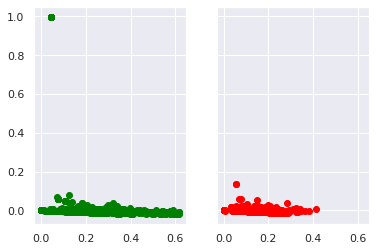

In [35]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True)
ax1.scatter(projection[:boundary, 0], projection[:boundary, 1], c='green')
ax2.scatter(projection[boundary:, 0], projection[boundary:, 1], c='red')

In [36]:
pca.explained_variance_ratio_

array([0.02717995, 0.02205876])

We see that a PCA projection down to 2 components is very interesting. Most datapoints seem to have a very low coordinate along the second component, withh one notable exception. The explained variance ratios are also quite low, probably because of the outlier as well. Let's take a closer look at it.

In [37]:
idx = np.where(projection[:, 1] > 0.9)
text_data.iloc[idx]

,text,title,truth
29,"[800, hotlin, cq, need, contact, 678-8511, hel...",[cq.com],real
34,"[800, hotlin, cq, need, contact, 678-8511, hel...",[cq.com],real
105,"[800, hotlin, cq, need, contact, 678-8511, hel...",[cq.com],real
116,"[800, hotlin, cq, need, contact, 678-8511, hel...",[cq.com],real
117,"[800, hotlin, cq, need, contact, 678-8511, hel...",[cq.com],real
157,"[800, hotlin, cq, need, contact, 678-8511, hel...",[cq.com],real
247,"[800, hotlin, cq, need, contact, 678-8511, hel...",[cq.com],real
251,"[800, hotlin, cq, need, contact, 678-8511, hel...",[cq.com],real
273,"[800, hotlin, cq, need, contact, 678-8511, hel...",[cq.com],real
364,"[800, hotlin, cq, need, contact, 678-8511, hel...",[cq.com],real


It looks like it wasn't one outlier after all, but several copies of the same news article. They looks more like noise then meaningful articles. Let's see how the projeciton behaves if we remove them.

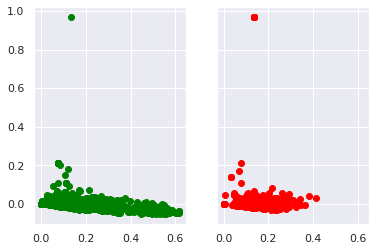

In [38]:
mask = np.ones(embedding.shape[0], dtype=bool)
mask[idx] = False
pca = TruncatedSVD(n_components=2, random_state=random_state)
limited_projection = pca.fit_transform(embedding[mask])

fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True)
ax1.scatter(limited_projection[:boundary, 0], limited_projection[:boundary, 1], c='green')
ax2.scatter(limited_projection[boundary:, 0], limited_projection[boundary:, 1], c='red')


It looks like we have new outliers now. It seems that most important information is captured along the first principal component, but there are many outliers in different directions. Instead of focusing on them, let's take a closer look at the group of real articles that are clearly separated from the fake ones.

In [39]:
text_data.iloc[np.where(projection[:, 0] > 0.4)]


,text,title,truth
12,"[competit, 10, call, kind, protect, approxim, ...","[may, gm, brief, 2009, restructur, background,...",real
14,"[apprenticeship, henri, 10, settl, call, talk,...","[presid, auto, resurg, american, remark, indus...",real
16,"[10, kind, paper, forth, back, pac, along, int...","[transcript, kain, 'thi, steel, week]",real
19,"[10, depend, kind, understand, professor, dire...","[gate, transcript, 'thi, boehner, week, hoyer,...",real
33,"[10, outmaneuv, kind, respons, anbar, krugman,...","[transcript, week, 'thi, biden]",real
...,...,...,...
502,"[depend, coward, kind, fro, reli, forth, back,...","[transcript, holder, giuliani, 'thi, week]",real
519,"[10, kind, gray, imposit, back, legitim, heavi...",[transcript],real
526,"[10, kind, germani, respons, forth, back, pac,...","[cnn/youtub, part, transcript, presidenti, dem...",real
539,"[feder, singl, talk, protect, student, kind, e...","[mark, halperin]",real


Unfortunately, there seems to be no clear signal here, as no single token really stands out. It is therefore likely that the first principal component is a linear combination of many different tokens. 

Although the projection doesn't seem very linearly separable, judging from the graph, we can still try a linear SVM classifier on it.

In [40]:
X_train, X_test, y_train, y_test = train_test_split(
    projection, labels, test_size=0.2, random_state=random_state)
svm_classifier = svm.SVC(kernel='linear')
svm_classifier.fit(X_train, y_train)
accuracy_score(y_test, svm_classifier.predict(X_test))

0.6290322580645161

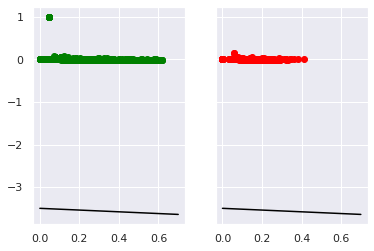

In [41]:
w = svm_classifier.coef_[0]
b = svm_classifier.intercept_[0]
x_points = np.linspace(0, 0.7)
y_points = -(w[0] / w[1]) * x_points - b / w[1]
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True)
ax1.scatter(projection[:boundary, 0], projection[:boundary, 1], c='green')
ax2.scatter(projection[boundary:, 0], projection[boundary:, 1], c='red')
ax1.plot(x_points, y_points, c='black')
ax2.plot(x_points, y_points, c='black')


The linear SVM achieves very poor performance. It classifies all articles as real and exploits the fact that the split between real and fake articles is not 50-50. We can perhaps achieve better performance by increasing the SVM parameter **C** and thus focusing more on reducing misclassification than on maximizing the margin.

In [42]:
svm_classifier = svm.SVC(C=100, kernel='linear')
svm_classifier.fit(X_train, y_train)
accuracy_score(y_test, svm_classifier.predict(X_test))


0.6021505376344086

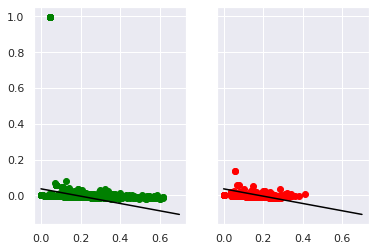

In [43]:
w = svm_classifier.coef_[0]
b = svm_classifier.intercept_[0]
x_points = np.linspace(0, 0.7)
y_points = -(w[0] / w[1]) * x_points - b / w[1]
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True)
ax1.scatter(projection[:boundary, 0], projection[:boundary, 1], c='green')
ax2.scatter(projection[boundary:, 0], projection[boundary:, 1], c='red')
ax1.plot(x_points, y_points, c='black')
ax2.plot(x_points, y_points, c='black')

We see that although the new classifier makes much more sense graphically, it's accuracy is actually worse than the previous "naive" one's. 

Let us also try the t-SNE projection to see how it compares to PCA.

In [44]:
intermediate_pca = TruncatedSVD(n_components=50, random_state=random_state)
tsne = TSNE(n_components=2, learning_rate='auto',
            init='random', random_state=random_state)

intermediate_matrix = intermediate_pca.fit_transform(embedding)
projection = tsne.fit_transform(intermediate_matrix)
projection.shape

(926, 2)

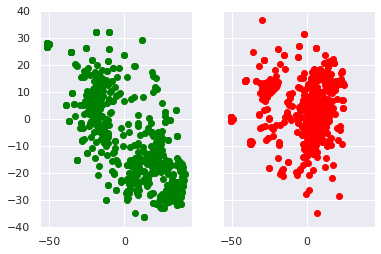

In [45]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True)
ax1.scatter(projection[:boundary, 0], projection[:boundary, 1], c='green')
ax2.scatter(projection[boundary:, 0], projection[boundary:, 1], c='red')


Again, the projection is very different from the PCA one. it also doesn't look very linearly separable, so we won't even try to fit a SVM model here. We can however try a SVM on the original matrix itself. 

In [46]:
X_train, X_test, y_train, y_test = train_test_split(
    embedding, labels, test_size=0.2, random_state=random_state)
svm_classifier = svm.SVC(kernel='linear')
svm_classifier.fit(X_train, y_train)
accuracy_score(y_test, svm_classifier.predict(X_test))

0.8655913978494624

We see that we can achieve very good performance with a simple linear SVM on the TF-IDF matrix. Can we achieve get even better performance with a nonlinear kernel?

In [47]:
svm_classifier = svm.SVC(kernel='rbf')
svm_classifier.fit(X_train, y_train)
accuracy_score(y_test, svm_classifier.predict(X_test))


0.8655913978494624

The accuracy of the nonlinear SVM is exactly the same as with a linear one. Although that could be a bug in our implementation, it could also just be the nature of this TF-IDF matrix. In any case, these models perform best so far.  

In [48]:
dump(svm_classifier, 'models/svm_news_tfidf.joblib')

['models/svm_news_tfidf.joblib']

## Analyzing tweets

Our analysis has so far been limited to new articles. However, our dataset also contains tweets about them. Let's analyze them as well.

First, we load the tweets from our dataset to a Pandas DataFrame object for easier usage. We use a helper function ``collect_tweets`` that also adds a ``truth`` value to the tweet, depending on what kind of news it is talking about. Let's see how the tweets look like. 

In [49]:
politifact_tweets = pd.DataFrame(collect_tweets(root_dir + datasets[0]))
politifact_tweets

,author_id,conversation_id,created_at,entities,id,lang,source,text,truth,in_reply_to_user_id,referenced_tweets,attachments,geo,withheld
0,32497478,133032062784503808,2011-11-06T04:04:50.000Z,"{'annotations': [{'end': 5, 'normalized_text':...",133032062784503808,en,TweetDeck,Romney favored support of the federal assault ...,real,NaN,NaN,NaN,NaN,NaN
1,32497478,135231654175318017,2011-11-12T05:45:13.000Z,"{'annotations': [{'end': 5, 'normalized_text':...",135231654175318017,en,TweetDeck,Romney favored support of the federal assault ...,real,NaN,NaN,NaN,NaN,NaN
2,2234711,138610074829594624,2011-11-21T13:29:51.000Z,"{'annotations': [{'end': 96, 'normalized_text'...",138610074829594624,en,Silver Bird,#GOP #tcot RT @sjh2222: 2nd Amendment http://t...,real,NaN,NaN,NaN,NaN,NaN
3,32497478,139099903497469952,2011-11-22T21:56:16.000Z,"{'annotations': [{'end': 5, 'normalized_text':...",139099903497469952,en,TweetDeck,Romney favored support of the federal assault ...,real,NaN,NaN,NaN,NaN,NaN
4,83949216,139102215238459392,2011-11-22T22:05:27.000Z,"{'annotations': [{'end': 5, 'normalized_text':...",139102215238459392,en,TweetDeck,Romney favored support of the federal assault ...,real,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
419526,39882689,790399441127649280,2016-10-24T03:48:06.000Z,"{'annotations': [{'end': 7, 'normalized_text':...",790399441127649280,en,Facebook,Bachmann: “White People Have Suffered More In ...,fake,NaN,NaN,NaN,NaN,NaN
419527,192726525,883382140729253894,2017-07-07T17:48:09.000Z,"{'annotations': [{'end': 7, 'normalized_text':...",883382140729253894,en,Twitter for iPhone,Bachmann: “White People Have Suffered More In ...,fake,NaN,NaN,NaN,NaN,NaN
419528,78663449,883414498576662529,2017-07-07T19:56:44.000Z,"{'annotations': [{'end': 7, 'normalized_text':...",883414498576662529,en,Facebook,Bachmann: “White People Have Suffered More In ...,fake,NaN,NaN,NaN,NaN,NaN
419529,133018525,883448484854202370,2017-07-07T22:11:47.000Z,"{'annotations': [{'end': 7, 'normalized_text':...",883448484854202370,en,Twitter Web Client,Bachmann: “White People Have Suffered More In ...,fake,NaN,NaN,NaN,NaN,NaN


We can see that we have more than 400k individual tweets, significantly more than the number of news articles. Let's check the proportions of tweets about real and fake articles.

As with the articles, our tweet objects also contain a lot of features, but a lot of them have missing values carry little useful information. We will again limit ourselves just to the text part of the tweets.

In [50]:
text_data = politifact_tweets[['text', 'truth']]
del politifact_tweets

In [51]:
text_data['truth'].value_counts()

real    306979
fake    112552
Name: truth, dtype: int64

We see that the tweets are quite unevenly distributed. Tweets about fake articles make up only about a quarter of all tweets. We will have to be very careful when drawing conclusions from our model performances. We can also again exploit the ordering of our tweets to remember the exact boundary index between tweets about real and fake articles.

In [52]:
boundary = 306979


The next natural step is to use our previously defined tokenization and lemmatization functions and to construct a term-document matrix. For tokenization, we will be using a special tweet tokenizer that keeps the hashtags as one token.

In [53]:
tokenizer = TweetTokenizer()
text_data = tokenize_clean(text_data, ['text'], tokenizer)
text_data = stem_lemmatize(text_data, ['text'])
vectorizer = CountVectorizer(
    lowercase=False,
    preprocessor=lambda x: x,
    stop_words=None,
    tokenizer=lambda x: text_data["text"][int(x)]
)

embedding = vectorizer.fit_transform(
    [str(i) for i in range(len(text_data["text"]))])

embedding

Using tokenizer: <nltk.tokenize.casual.TweetTokenizer object at 0x7f89afb08430>


<419531x283518 sparse matrix of type '<class 'numpy.int64'>'
	with 5831817 stored elements in Compressed Sparse Row format>

We can see from the matrix dimensions that the vocabulary size is approximately 280k, about 10 times as much as in the articles, while the number of all tweets is more than 400 times as much as the number of articles. This is concurrent with the theory, which suggests that vocabulary size follows Heap's law: $V = k N^\beta$, where $V$ is the size of the vocabulary, $N$ is the corpus size and $k, \beta$ are constants, with $\beta$ usually being around $0.7$.

Let's see which tokens are most frequent.

In [54]:
tokens = frequent_tokens(embedding)
tokens

,token,score
64,u,48917
712,trump,47428
171,...,42974
464,one,36868
322,state,33297
...,...,...
60068,customer-centr,2
60071,stanst,2
60072,@theorangecon,2
60074,stamped,2


The very general tokens 'u' and '...' are of course among the most frequent ones, along with 'trump'. About a third of all tokens appear at least twice in the corpus, just like with the articles.

(0.0, 0.1)

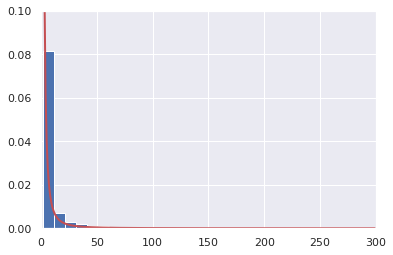

In [55]:
a = 2
x = np.arange(1.0, 300.0)
y = x**(-a) / special.zetac(a)
count, bins, ignored = plt.hist(tokens['score'], bins=5000, density=True)
plt.plot(x, y/max(y), linewidth=2, color='r')
ax = plt.gca()
ax.set_xlim([0, 300])
ax.set_ylim([0, 0.1])

We can see that the distribution again closely matches the Zipfian one.

Our next step is to visualize our high-dimensional dataset. We must again use some dimensionality reduction techniques. We will again start with a simple PCA.

In [56]:
pca = TruncatedSVD(n_components=2, random_state=random_state)
projection = pca.fit_transform(embedding)
projection.shape

(419531, 2)

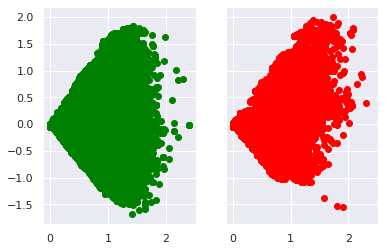

In [57]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True)
ax1.scatter(projection[:boundary, 0], projection[:boundary, 1], c='green')
ax2.scatter(projection[boundary:, 0], projection[boundary:, 1], c='red')

We can see that the distributons of tweets about real and fake articles are roughly similar, with a noticable predominance of real ones in the bottom region of the graph. Let's take a closer look at those.

In [58]:
bottom = text_data[projection[:, 1] < -1]
bottom['truth'].value_counts()


real    2627
fake     285
Name: truth, dtype: int64

We can see that the bottom region indeed contains mostly tweets about real articles. What do there tweets look like?

In [59]:
bottom['text'].head(10)

6731     [point, interview, @realdonaldtrump, kim, get,...
9193     [10, @cbsnew, msm, presid, rate, approv, even,...
10887    [post, left, facebook, @detroitpublictv, howev...
11992    [interview, presid, putin, vladimir, interview...
11993    [interview, presid, putin, vladimir, interview...
11997    [interview, presid, putin, vladimir, interview...
12124    [interview, presid, putin, vladimir, interview...
12129    [helsinki, interview, presid, putin, vladimir,...
12811    [helsinki, bigger, @cbsnew, summit, presid, am...
13055    [helsinki, presid, putin, vladimir, council, n...
Name: text, dtype: object

In [60]:
bottom['text'].tail(10)


377077    [point, @gatewaypundit, presid, rate, approv, ...
377108    [point, neg, @gatewaypundit, presid, better, #...
377227    [point, @gatewaypundit, liber, presid, better,...
377229    [post, point, presid, poll, better, read, news...
377272    [point, presid, poll, better, updat, read, new...
379681    [suspect, facebook, protect, news, today, nati...
380321    [clarifi, presid, russia, clarifi, news, ..., ...
390519    [agent, visit, interview, news, snake, watch, ...
393371    [real, utin, greed, get, trump, countri, unit,...
398366    [makeup, trump, @realdonaldtrump, oppos, offic...
Name: text, dtype: object

We can see that the token *presid*, a stem of *president*, is seemingly present in most of these tweets. Let's see if this observation scales over the whole datatset.

In [61]:
word_truths(text_data, 'presid', normalize=True)

real    0.853789
fake    0.146211
Name: truth, dtype: float64

We can see that the token 'presid' does indeed mostly appear in tweets about real articles. We have to remmeber though, that our dataset is quite unbalanced and contains many more tweets about real articles in general, so we can't be too confident in this conclusion.

We can also remember that in articles, the token 'transcript' was also mostly associated with real articles. Does the same hold for tweets?

In [62]:
word_truths(text_data, 'transcript', normalize=True)

real    0.988787
fake    0.011213
Name: truth, dtype: float64

The results are quite remarkable. Almost **99%** of tweets containing 'transcript' are about real articles!

Next, we can try the SVM classifiers we trained on articles on our tweet data. From the PCA visualization, it doesn't look like the projection is very linearly separable, so we can't expect much.

In [63]:
labels = np.array(
    [1 if truth == "real" else 2 for truth in text_data['truth']])

svm_classifier = load('models/svm_news_pca.joblib')
accuracy_score(labels, svm_classifier.predict(projection))


0.6555200926749155

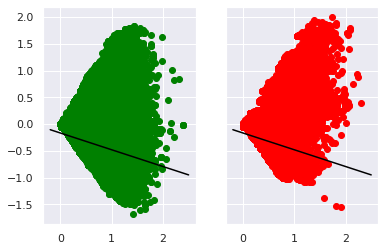

In [64]:
w = svm_classifier.coef_[0]
b = svm_classifier.intercept_[0]
x_points = np.linspace(-0.2, 2.5)
y_points = -(w[0] / w[1]) * x_points - b / w[1]
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True)
ax1.scatter(projection[:boundary, 0], projection[:boundary, 1], c='green')
ax2.scatter(projection[boundary:, 0], projection[boundary:, 1], c='red')
ax1.plot(x_points, y_points, c='black')
ax2.plot(x_points, y_points, c='black')

We see that the linear model trained on article PCA projection doesn't perform that well. Most of the accuracy comes from exploiting the unbalanced structure of the dataset.

Unfortunately, we can't use the model that was trained on the whole article matrix, as the vocabulary dimensions don't match. We could theoretically project the tweet data down to the size of article vocabulary, but in practice, the resulting dense matrix would be too large to fit in memory (about 60GB).

Instead, let us see how the tweet data looks if we use a TF-IDF vectorizer.

In [65]:
tf_idf_transformer = TfidfTransformer()
embedding = tf_idf_transformer.fit_transform(embedding)
embedding

<419531x283518 sparse matrix of type '<class 'numpy.float64'>'
	with 5831817 stored elements in Compressed Sparse Row format>

To visualize, we again need to use PCA.

In [66]:
pca = TruncatedSVD(n_components=2, random_state=random_state)
projection = pca.fit_transform(embedding)
projection.shape

(419531, 2)

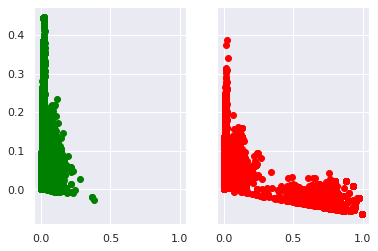

In [67]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True)
ax1.scatter(projection[:boundary, 0], projection[:boundary, 1], c='green')
ax2.scatter(projection[boundary:, 0], projection[boundary:, 1], c='red')

The PCA projection of TF-IDF matrix looks very interesting. It appears that the first two principal components are very uncorrelated, and that high value along the first component indicates tweets about fake articles. Let's take a closer look at them.

In [68]:
text_data[projection[:, 0] > 0.5]

,text,truth
332159,"[doctor, vaccin, cancer, murder, enzym, found,...",fake
332160,"[doctor, vaccin, cancer, murder, enzym, found,...",fake
332161,"[doctor, vaccin, cancer, murder, enzym, found,...",fake
332162,"[doctor, vaccin, babi, cancer, enzym, murder, ...",fake
332163,"[doctor, vaccin, cancer, murder, enzym, found,...",fake
...,...,...
337190,"[doctor, vaccin, via, cancer, enzym, murder, f...",fake
337191,"[doctor, vaccin, cancer, murder, enzym, found,...",fake
337192,"[doctor, vaccin, cancer, murder, enzym, found,...",fake
337193,"[doctor, may, #realnew, vaccin, 12, cancer, mo...",fake


We notice that these tweets seem to all be about vaccinations, indicating that the first principal component might measure that. Let's also take a look at how the token 'vaccin' is distributed among all tweets.

In [69]:
word_truths(text_data, 'vaccin')

fake    6414
real     517
Name: truth, dtype: int64

We can see that tweets about vaccines are indeed mostly referencing the fake news articles. However, interestingly enough, these tweets make up a very small amount of our entire dataset. 

Let's also take a look at tweets along the second principal component.


In [70]:
text_data[projection[:, 1] > 0.4]

,text,truth
56748,"[presid, statement]",real
56749,"[presid, statement]",real
56750,"[presid, statement]",real
56751,"[presid, statement]",real
56752,"[presid, statement]",real
...,...,...
291767,"[transcript, cb, interview, presid, trump, nat...",real
291776,"[transcript, cb, interview, presid, trump, nat...",real
291778,"[transcript, cb, interview, presid, trump, nat...",real
292019,"[transcript, interview, presid, cb, nation, do...",real


This principal component seems to be mostly associated with tweets about the pesident. As we have seen earlier, these tweets tend to be more about real articles.

Overall, we can conclude that the both the article and the tweet dataset are very complex. While we were able to identify some interesting tokens that seem to be a good indicator of the validity of an article or an associated tweet, like 'transcript', 'presid' and 'vaccin', actual prediction remains hard, not least because of the the variable vocabulary size between articles and tweets. Highly unbalanced classes further undermine the certainty of our models. We have also learned that it is hard to visualize these high-domensional spaces, as their projections down to 2 components seldom retain a lot of information. And ultimately, we have noticed the larger our dataset isdatatset, the harder it is to have an accurate idea about how the raw data actually looks like.